In [ ]:
from utils import get_scanpy_lfcs, get_seurat_lfcs, get_ZILN_lfcs, transform
import numpy as np
import matplotlib.pyplot as plt

### In the next (jupyter) cell we show that when the gene count distributions are the same for all genes for all cells/samples in a group/condition, then the normalization pre-processing step makes the means of the control and treatment distributions indistinguishable. This is true even if there is a big LFC between the two groups. Further down you'll find a proof that this holds in theory, too.

In [ ]:
r_x = 1
r_y = 80
p = 0.6
true_lfc = np.log2(r_y / r_x)

X = np.random.negative_binomial(r_x, p, size=(500, 1000))
Y = np.random.negative_binomial(r_y, p, size=(500, 1000))

fig = plt.figure(figsize=(8, 8))

# Left column
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 3, sharex=ax1)  # Share x-axis with ax1

# Right column
ax3 = plt.subplot(2, 2, 2)
ax4 = plt.subplot(2, 2, 4, sharex=ax3)  # Share x-axis with ax3

# Plot data
ax1.hist(X[:, 0], bins=100, color='red', label='control')
ax2.hist(Y[:, 0], bins=100, color='blue', label='treatment')
ax1.legend()
ax2.legend()

ax3.hist(np.exp(transform(X)[:, 0]) - 1, bins=100, color='red', label='control (normalized)')
ax4.hist(np.exp(transform(Y)[:, 0]) - 1, bins=100, color='blue', label='treatment (normalized)')
ax3.legend()
ax4.legend()

plt.tight_layout()
plt.show()

This is to be expected as the normalization effectively removes the dependence of the NB parameters on the mean of an NB, as outlined below.

**Given:** 
- $G$ is the number of genes.
- $ X_1, X_2, \ldots, X_G $ are i.i.d. random variables, each following a Negative Binomial distribution $ \text{NB}(r, p) $. 
- Define $S_G = \sum_{i=1}^G X_i$.

We want to find:
$
\mathbb{E}\left[\frac{X_i}{S_G}\right].
$

Because the $X_i$ are i.i.d., the joint distribution is symmetric with respect to any permutation of the indices. Thus:
$
\mathbb{E}\left[\frac{X_1}{S_G}\right] = \mathbb{E}\left[\frac{X_2}{S_G}\right] = \cdots = \mathbb{E}\left[\frac{X_G}{S_G}\right].
$

Let this common expectation be $\mu$. Then:
$
\frac{X_1}{S_G} + \frac{X_2}{S_G} + \cdots + \frac{X_G}{S_G} = 1.
$

Taking expectations:
$
\mathbb{E}\left[\frac{X_1}{S_G}\right] + \mathbb{E}\left[\frac{X_2}{S_G}\right] + \cdots + \mathbb{E}\left[\frac{X_G}{S_G}\right] = 1.
$

Since each term is $\mu$, we have:
$
G\mu = 1 \implies \mu = \frac{1}{G}.
$

Therefore:
$
\mathbb{E}\left[10k \times \frac{X_i}{S_G}\right] = \frac{10k}{G}
$ **and** $\mathbb{E}\left[10k \times \frac{Y_i}{P_G}\right] = \frac{10k}{G},$

where $Y_i$ is a draw from the treatment's NB with other, arbitrary parameters and $P_G$ is the sum of these $G$ draws.

So in a setting where we want to compare the LFC of gene $g$ between the two groups, we would test

LFC = $\log_2\mathbb{E}\left[10k \times \frac{Y_i}{P_G}\right] - \log_2 \mathbb{E}\left[10k \times \frac{X_i}{S_G}\right] = \log_2 \frac{10k}{G} - \log_2 \frac{10k}{G} = 0$.  

In the next step, we show the effects of this on the LFC estimates and then do the LFC estimates without normalization.

In [ ]:
ziln_lfcs = get_ZILN_lfcs(np.exp(transform(X)) - 1, np.exp(transform(Y)) - 1, eps=1e-3)
suerat_lfcs = get_seurat_lfcs(X, Y, normalize=True)
scanpy_lfcs = get_scanpy_lfcs(X, Y, normalize=True)

_, axs = plt.subplots(3, 1, sharex=True)
for ax, (lfcs, name) in zip(axs, [(ziln_lfcs, "ziln"), (suerat_lfcs, "seurat"), (scanpy_lfcs, 'scanpy')]):
    ax.hist(lfcs.flatten(), bins=100, density=True, label=name)
    ax.axvline(true_lfc, 0, 1, color='red', label='true lfc')
    ax.legend()
plt.show()

The difference in log-means (i.e. the LFCs) of the normalized data sets **is** zero, so it's peculiar that scanpy finds a signal in this setting! Scanpy only finds an LFC signal when there one of the distributions produces sparse count data (you can try decreasing for instance $r_y$ in the code snippet two cells up). 

As said, now we remove the normalization and again estimate the LFCs.

In [ ]:
ziln_lfcs = get_ZILN_lfcs(X, Y, eps=0)
suerat_lfcs = get_seurat_lfcs(X, Y, normalize=False)
scanpy_lfcs = get_scanpy_lfcs(X, Y, normalize=False)

_, axs = plt.subplots(3, 1, sharex=True)
for ax, (lfcs, name) in zip(axs, [(ziln_lfcs, "ziln"), (suerat_lfcs, "seurat"), (scanpy_lfcs, 'scanpy')]):
    if name == 'seurat': 
        # Removes the estimation error from Seurat, however it will only work whenever mean(Z) > 0
        lfcs -= np.log2((1 + 1 / np.mean(Y)) / (1 + 1 / np.mean(X)))
    ax.hist(lfcs.flatten(), bins=100, density=True, label=name)
    ax.axvline(true_lfc, 0, 1, color='red', label='true lfc')
    ax.legend()
plt.show()

Interestingly, neither Seurat or Scanpy are able to accurately estimate the LFCs when at least one of the NBs give sparse counts.

Let's look at the LFC estimators of gene $g$ (without normalization) used in the two softwares:

**Seurat:** $\text{LFC}_g^\text{SE} = \log_2(f(Y_{1:n, g})) - \log_2(f(X_{1:n', g}))$, 

where $f(Y_{1:n, g}) = \frac{1}{n}\sum_i \left(e^{\log (Y_{i,g} + 1)} - 1\right) + 1 = \frac{1}{n}\sum_i \left(Y_{i,g} + 1 - 1\right) + 1 = \frac{1}{n}\sum_i \left(Y_{i,g} \right) + 1$.

Consequently, $\text{LFC}_g^\text{SE} = \log_2\left( \frac{1}{n}\sum_i \left(Y_{i,g} \right) + 1 \right) - \log_2\left( \frac{1}{n'}\sum_i \left(X_{i,g} \right) + 1 \right).$

### Analyzing $\log_2\left(\frac{1}{n}\sum Y_{i} + 1\right) - \log_2 \mathbb{E}[Y]$

By Jensen's inequality, $\mathbb{E}\left[ \log_2\left(\frac{1}{n}\sum Y_{i} + 1\right)\right] \leq \log_2\left(\mathbb{E}[Y] + 1\right)$, with equality as $n$ grows. Hence, $\log_2\left(\frac{1}{n}\sum Y_{i} + 1\right)$ is unsurprisingly a biased estimator of $\log_2 \mathbb{E}[Y_i]$.

Assuming that $\mathbb{E}[Y_i]$ is small, we can do the following approximation:

$\log_2\left(\mathbb{E}[Y] + 1\right) \approx \frac{\mathbb{E}[Y]}{\log(2)}$, which goes to zero with $\mathbb{E}[Y]$.

Meanwhile, $\log_2 \mathbb{E}[Y]$ goes to $-\infty$ as $\mathbb{E}[Y]\rightarrow 0$, hence the difference between the estimator and the true NB mean, $\log_2\left(\frac{1}{n}\sum Y_{i} + 1\right) - \log_2 \mathbb{E}[Y]$, goes to infinity as $\mathbb{E}[Y]$ decreases, for sufficiently large sample sizes ($n$, number of cells). 

Although the asymptotic perspective, w.r.t. the number of cells, is necessary for rigour, in practice the estimator will produce non-accurate, overshooting estimates of $\log_2 \mathbb{E}[Y]$.

Below we plot an example.

In [ ]:
p = 0.6
n = int(1e1)

means = []
rs = np.exp(np.linspace(-10, 0, 100))[::-1]
for r in rs:
    x_n = np.random.negative_binomial(r, p, size=(100, n))
    means.append(np.mean(np.log2(np.mean(x_n, axis=1) + 1), axis=0))
    

plt.rcParams.update({
    'font.size': 14,       # base font size
    'axes.labelsize': 16,  # axes labels
    'xtick.labelsize': 14, # x-tick labels
    'ytick.labelsize': 14, # y-tick labels
    'legend.fontsize': 14  # legend font size
})

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot the first line on the primary y-axis
color1 = 'blue'
ax1.plot(means, label=r'$\log_2\frac{1}{n}\sum Y_{i} + 1$', color=color1)
ax1.set_xlabel(r"$r_y$")
# ax1.set_ylabel(r'$\mathbb{E}\left[\log(\frac{1}{n}\sum Y_i + 1)\right]$', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second line on the secondary y-axis
color2 = 'red'
ax2.plot(-np.log2(rs * (1 - p) / p), label=r'$-\log(\mathbb{E}[Y_i])$', color=color2)
ax2.plot(np.array(means) - np.log2(rs * (1 - p) / p), label=r'Blue + Red', color=color2, linestyle=':')
# ax2.set_ylabel(r'$-\log r_y$', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Adjust x-ticks and labels
ax1.set_xticks([0, len(means)])
ax1.set_xticklabels([1, "Practically zero"])

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

plt.tight_layout()
plt.show()

## LFC estimation error of Seurat
We analyze the expected LFC estimation error in the limit of the number of cells, i.e. we let $n, n' \rightarrow \infty$. This allows us to examine the errors in terms of $\mathbb{E}[Y]$ and $ \mathbb{E}[X]$, since

$\lim_{n,n'\rightarrow \infty}\mathbb{E}\left[\text{LFC}^\text{SE}\right] = \lim_{n\rightarrow \infty}\mathbb{E}\left[\log_2\left( \frac{1}{n}\sum_i Y_i + 1 \right)\right] - \lim_{n'\rightarrow \infty}\mathbb{E}\left[\log_2\left( \frac{1}{n'}\sum_i X_i + 1 \right)\right] = \mathbb{E}\left[\log_2\left( \mathbb{E}[Y] + 1 \right)\right] - \mathbb{E}\left[\log_2\left( \mathbb{E}[X] + 1 \right) \right]= \log_2\left( \frac{\mathbb{E}[Y] + 1}{\mathbb{E}[X] + 1} \right)$ 

and so

$\mathbb{E}[\text{error}] = \lim_{n,n'\rightarrow \infty}\mathbb{E}\left[\text{LFC}^\text{SE}\right] - \text{LFC} = \log_2\left(\frac{\mathbb{E}[Y] + 1}{\mathbb{E}[X] + 1} \right) - \log_2\left(\frac{\mathbb{E}[Y]}{\mathbb{E}[X]}\right) =  \log_2\left(\frac{\mathbb{E}[Y] + 1}{\mathbb{E}[X] + 1} \frac{\mathbb{E}[X]}{\mathbb{E}[Y]} \right) = \log_2\left(\frac{1 + 1 / \mathbb{E}[Y]}{1 + 1/ \mathbb{E}[X]}\right)$ 

In [ ]:
r_x = 80
r_y = 0.01
p = 0.6
true_lfc = np.log2(r_y / r_x)

E_X = r_x * (1 - p) / p
E_Y = r_y * (1 - p) / p

X = np.random.negative_binomial(r_x, p, size=(10000, 1))
Y = np.random.negative_binomial(r_y, p, size=(10000, 1))

suerat_lfcs = get_seurat_lfcs(X, Y, normalize=False)
print("Empirical error: ", suerat_lfcs - true_lfc)
print("Analytical error", np.log2((1 + (1 / E_Y)) / (1 + (1 / E_X))))

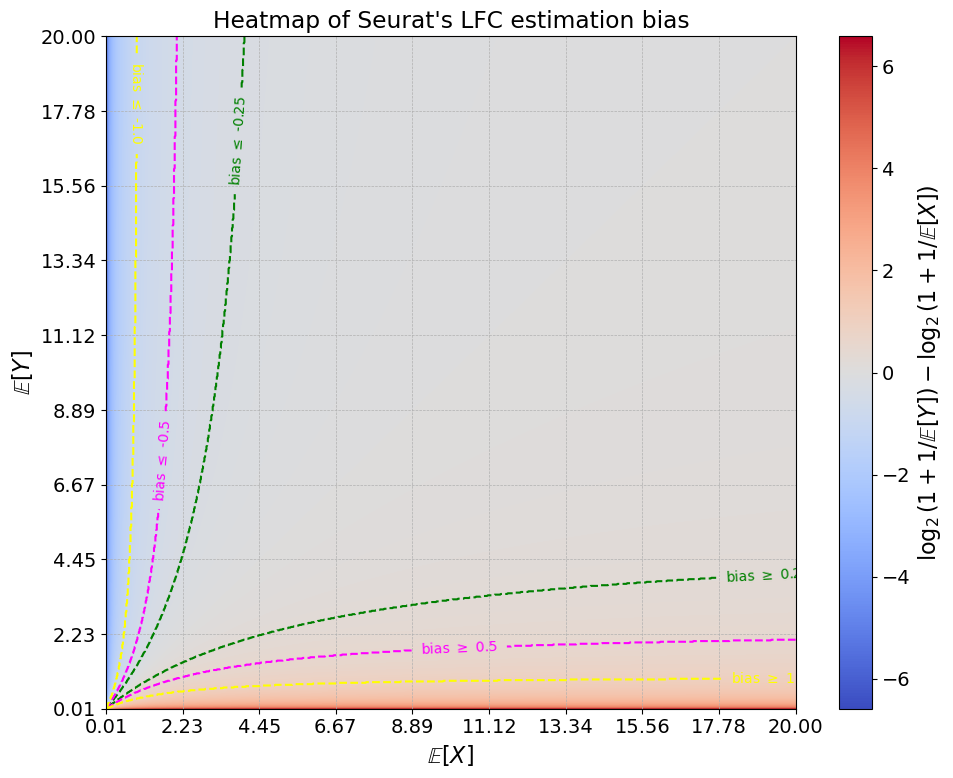

In [179]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range for EX and EY
ex = np.linspace(0.01, 20, 1000)
ey = np.linspace(0.01, 20, 1000)

EX, EY = np.meshgrid(ex, ey)

# Define the function f(EX, EY)
F = np.log2(1 + 1/EY) - np.log2(1 + 1/EX)

F_rounded = np.round(F, 100)

# Create the heatmap
plt.figure(figsize=(10, 8))
heatmap = plt.imshow(F_rounded, extent=[ex.min(), ex.max(), ey.min(), ey.max()], origin='lower', aspect='auto', cmap='coolwarm')

# Add color bar
plt.colorbar(heatmap, label='$\log_2(1 + 1/\mathbb{E}[Y]) - \log_2(1 + 1/\mathbb{E}[X])$')

# Highlight regions where f <= -2 or f >= 2

for cap, color in zip([0.25, 0.5, 1.], ['green', 'magenta', 'yellow']):
    mask_lower = F_rounded <= -cap
    mask_upper = F_rounded >= cap
    
    # Add contours for the highlighted regions
    lower_contour = plt.contour(EX, EY, mask_lower, levels=[0.5], colors=color, linewidths=1.5, linestyles='--', extent=[ex.min(), ex.max(), ey.min(), ey.max()])
    upper_contour = plt.contour(EX, EY, mask_upper, levels=[0.5], colors=color, linewidths=1.5, linestyles='--', extent=[ex.min(), ex.max(), ey.min(), ey.max()])
    plt.clabel(upper_contour, inline=True, fontsize=10, fmt={0.5: f'bias $\geq$ {cap}'}, colors=color)
    plt.clabel(lower_contour, inline=True, fontsize=10, fmt={0.5: f'bias $\leq$ -{cap}'}, colors=color)



# Add labels
plt.xlabel('$\mathbb{E}[X]$')
plt.ylabel('$\mathbb{E}[Y]$')
plt.title("Heatmap of Seurat's LFC estimation bias")

# Add gridlines and ticks for better visualization
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.xticks(np.round(np.linspace(ex.min(), ex.max(), 10), 2))
plt.yticks(np.round(np.linspace(ey.min(), ey.max(), 10), 2))

# Adjust layout
plt.tight_layout()
plt.show()


### Scanpy analysis

$\text{LFC}_g^\text{SC} = \log_2(g(Y_{1:n, g})) - \log_2(g(X_{1:n', g}))$, 

where $g(Y_{1:n, g}) =  e^{\frac{1}{n}\sum_i \log (Y_{i,g} + 1)} - 1 + \epsilon = \prod_{i}\left(Y_{i,g} + 1\right)^{\frac{1}{n}} - 1 + \epsilon$.

Consequently, $\text{LFC}_g^\text{SC} = \log_2\left(\prod_{i}\left(Y_{i,g} + 1\right)^{\frac{1}{n}} - 1 + \epsilon\right) - \log_2\left( \prod_{i}\left(X_{i,g} + 1\right)^{\frac{1}{n}} - 1 + \epsilon \right).$





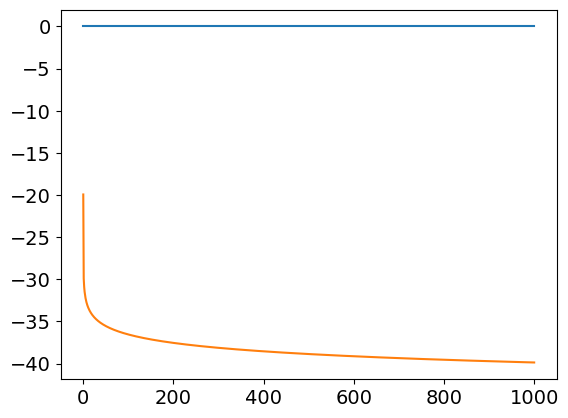

-29.897352853986263


In [188]:
eps = 1e-9
ub = []
lb = []

ey = np.linspace(0.001, 1000., 1000)
for E_Y in ey:
    ub.append(1 + eps / E_Y)
    lb.append(eps / E_Y)

plt.plot(ey, np.log2(1 + eps / ey))
plt.plot(ey, np.log2(eps / ey))
plt.show()

print(np.log2(eps))

## Non-uniformly distributed gene counts with batch effect

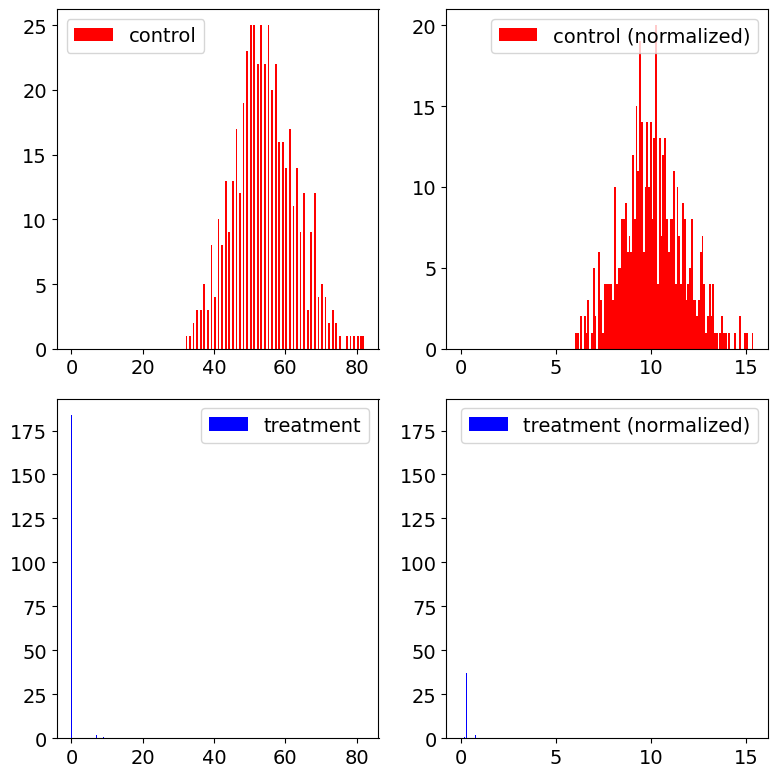

In [213]:
r_x = np.ones((1, 1000)) * 80
r_y = np.ones((1, 1000)) * 80 * 2
idx = np.random.randint(0, 1000, 20)
r_y[:, idx] = 2 
p = 0.6
true_lfc = np.log2((r_y / 2) / r_x)

X = np.random.negative_binomial(r_x, p, size=(500, 1000))
Y = np.random.negative_binomial(r_y, p, size=(500, 1000))

fig = plt.figure(figsize=(8, 8))

# Left column
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 3, sharex=ax1)  # Share x-axis with ax1

# Right column
ax3 = plt.subplot(2, 2, 2)
ax4 = plt.subplot(2, 2, 4, sharex=ax3)  # Share x-axis with ax3

# Plot data
# ax1.hist(X[:, 0], bins=100, color='red', label='control')
ax1.hist(X[:, idx[0]], bins=100, color='red', label='control')
# ax2.hist(Y[:, 0], bins=100, color='blue', label='treatment')
ax2.hist(Y[:, idx[0]], bins=100, color='blue', label='treatment')
ax1.legend()
ax2.legend()

ax3.hist(np.exp(transform(X)[:, idx[0]]) - 1, bins=100, color='red', label='control (normalized)')
ax4.hist(np.exp(transform(Y)[:, idx[0]]) - 1, bins=100, color='blue', label='treatment (normalized)')
ax3.legend()
ax4.legend()

plt.tight_layout()
plt.show()

In [293]:
same_r = 1
batch_effect = 1/2
n_genes = 1000
r_x = np.ones((1, n_genes)) * same_r
r_y = np.ones((1, n_genes)) * same_r * batch_effect
n_differentiated_genes = 10
n_cells = 1000
idx = np.random.randint(0, n_genes, n_differentiated_genes)
r_y[:, idx] = np.random.uniform(0, 10, n_differentiated_genes) 
p = 0.1
true_lfc = np.log2((r_y / batch_effect) / r_x)

E_X = r_x * (1 - p) / p
E_Y = r_y * (1 - p) / p / batch_effect

X = np.random.negative_binomial(r_x, p, size=(n_cells, n_genes))
Y = np.random.negative_binomial(r_y, p, size=(n_cells, n_genes))

ziln_lfcs = get_ZILN_lfcs(np.exp(transform(X)) - 1, np.exp(transform(Y)) - 1, eps=0)
suerat_lfcs = get_seurat_lfcs(X, Y, normalize=True)
scanpy_lfcs = get_scanpy_lfcs(X, Y, normalize=True)
true_lfc = true_lfc.flatten()

for ax, (lfcs, name) in zip(axs, [(ziln_lfcs, "ziln"), (suerat_lfcs, "seurat"), (scanpy_lfcs, 'scanpy')]):
    print(name)
    if name == 'seurat':
        # The expected error is only correct when the data is not normalized
        print("Expected error: ", np.log2(1 + 1 / E_Y[:, idx[0]]) - np.log2(1 + 1 / E_X[:, idx[0]]))
    print("|LFC| > 0 :", np.mean(np.abs(lfcs[idx] - true_lfc[idx])))
    print("|LFC| = 0 :", np.mean(np.abs(lfcs[~idx] - true_lfc[~idx])))

ziln
|LFC| > 0 : 0.1973286617360758
|LFC| = 0 : 0.26111338670335693
seurat
Expected error:  [-0.12662653]
|LFC| > 0 : 0.2415987836774486
|LFC| = 0 : 0.15839204381407956
scanpy
|LFC| > 0 : 0.46788070515864477
|LFC| = 0 : 0.7311989513910422
